In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 



In [2]:

from recidiviz.calculator.modeling.population_projection.simulations.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.compartment_transitions import CompartmentTransitions
from recidiviz.calculator.modeling.population_projection.release_transitions import ReleasedTransitions
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
import pandas as pd
from functools import partial
import yaml

In [31]:
test_sim = SuperSimulationFactory.build_super_simulation('../state/AZ/AZ_state_prison_HB_2376_model_inputs.yaml')
# test_sim.simulate_baseline(['prison'])

/Users/pacopoler/.local/share/virtualenvs/pulse-data-Jd9N3JcA/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1728: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


outflows_data returned 432 results
transitions_data returned 30 results
total_population_data returned 216 results


In [30]:
test_sim.data_dict['total_population_data']

,simulation_tag,time_step,compartment,total_population,crime,crime_type,age,race,date_created
0,AZ_HB_2376,-3,prison,2770.0,None,Class 1,None,None,2021-01-09 00:45:41.783825+00:00
1,AZ_HB_2376,-3,prison,13726.0,None,Class 2,None,None,2021-01-09 00:45:41.783825+00:00
2,AZ_HB_2376,-3,prison,11055.0,None,Class 3,None,None,2021-01-09 00:45:41.783825+00:00
3,AZ_HB_2376,-3,prison,10696.0,None,Class 4,None,None,2021-01-09 00:45:41.783825+00:00
4,AZ_HB_2376,-3,prison,1621.0,None,Class 5,None,None,2021-01-09 00:45:41.783825+00:00
5,AZ_HB_2376,-3,prison,2332.0,None,Class 6,None,None,2021-01-09 00:45:41.783825+00:00
6,AZ_HB_2376,-2,prison,2797.0,None,Class 1,None,None,2021-01-09 00:45:41.783825+00:00
7,AZ_HB_2376,-2,prison,13805.0,None,Class 2,None,None,2021-01-09 00:45:41.783825+00:00
8,AZ_HB_2376,-2,prison,10800.0,None,Class 3,None,None,2021-01-09 00:45:41.783825+00:00
9,AZ_HB_2376,-2,prison,10830.0,None,Class 4,None,None,2021-01-09 00:45:41.783825+00:00


In [32]:
LOS = test_sim.data_dict['transitions_data'][test_sim.data_dict['transitions_data'].compartment == 'prison'][['crime_type', 'compartment_duration']]
LOS.index = LOS.crime_type
LOS = LOS.drop('crime_type', axis=1)
LOS['mandatory_minimum'] = pd.Series({f"Class {i}": j for i,j in {1: None,2: 4, 3: 2.5, 4: 1.5, 5: 0.75, 6: 0.5}.items()}) * 12
LOS['sudo_stddev'] = (LOS.compartment_duration - LOS.mandatory_minimum) / LOS.compartment_duration
LOS = LOS.drop('Class 1', axis=0)
LOS


,compartment_duration,mandatory_minimum,sudo_stddev
crime_type,,,
Class 2,77.355943,48.0,0.379492
Class 6,6.623339,6.0,0.094113
Class 5,12.568878,9.0,0.283946
Class 3,37.586538,30.0,0.201842
Class 4,19.073089,18.0,0.056262


initialization time:  68.31765389442444
simulation_time:  67.23912715911865
initialization time:  68.65946960449219
simulation_time:  68.46959114074707


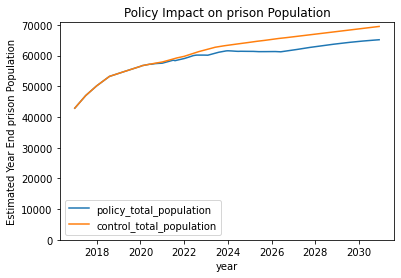

In [37]:
affected_fraction = 0.40

# Policy Option Methods
def optional_mm(crime_type, retroactive=False):
    return partial(CompartmentTransitions.apply_reduction, 
                   reduction_df=pd.DataFrame({'outflow': ['release'], 'affected_fraction': [affected_fraction], 
                                              'reduction_size': [LOS.loc[crime_type, 'sudo_stddev']]}),
                   reduction_type='*',
                   retroactive=retroactive)


policy_list_non_retroactive = [
    SparkPolicy(policy_fn=optional_mm(crime_type),
                spark_compartment='prison',
                sub_population={'crime_type': crime_type},
                apply_retroactive=False)
    for crime_type in LOS.index
]
    
test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'prison')

In [38]:
simulation_tag = 'AZ_HB_2376_40%'
test_sim.upload_simulation_results_to_bq('recidiviz-staging', simulation_tag)

In [5]:
test_results

(      jail  release        prison
 year                             
 2016   0.0      0.0  0.000000e+00
 2017   0.0      0.0  0.000000e+00
 2018   0.0      0.0  0.000000e+00
 2019   0.0      0.0  0.000000e+00
 2020   0.0      0.0  0.000000e+00
 2021   0.0      0.0  0.000000e+00
 2022   0.0     -0.0  1.315663e+07
 2023   0.0     -0.0  3.163027e+07
 2024   0.0     -0.0  5.424741e+07
 2025   0.0     -0.0  8.023826e+07,
       jail      release       prison
 year                                
 2016   0.0     0.000000     0.000000
 2017   0.0     0.000000     0.000000
 2018   0.0     0.000000     0.000000
 2019   0.0     0.000000     0.000000
 2020   0.0     0.000000     0.000000
 2021   0.0     0.000000     0.000000
 2022   0.0  -409.277499   409.277498
 2023   0.0  -983.956718   983.956715
 2024   0.0 -1687.532192  1687.532187
 2025   0.0 -2496.057356  2496.057350)

In [6]:
test_sim.output_data['life_years']

,jail,release,prison
year,,,
2016,0.0,0.000000,0.000000
2017,0.0,0.000000,0.000000
2018,0.0,0.000000,0.000000
2019,0.0,0.000000,0.000000
2020,0.0,0.000000,0.000000
2021,0.0,0.000000,0.000000
2022,0.0,-409.277499,409.277498
2023,0.0,-983.956718,983.956715
2024,0.0,-1687.532192,1687.532187


In [7]:
test_sim.output_data['cost_avoidance']

,jail,release,prison
year,,,
2016,0.0,0.0,0.000000e+00
2017,0.0,0.0,0.000000e+00
2018,0.0,0.0,0.000000e+00
2019,0.0,0.0,0.000000e+00
2020,0.0,0.0,0.000000e+00
2021,0.0,0.0,0.000000e+00
2022,0.0,-0.0,1.315663e+07
2023,0.0,-0.0,3.163027e+07
2024,0.0,-0.0,5.424741e+07
